<a href="https://colab.research.google.com/github/aayush1693/Lung-Cancer-Detection-using-CNN/blob/main/lung_cancer_detection_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am gonna build a classifier using a simple Convolution Neural Network which can classify normal lung tissues from cancerous. This project has been developed using Google Colab and the dataset has been taken from Kaggle

# **Modules Used**
Python libraries make it very easy for us to handle the data and perform typical and complex tasks with a single line of code.



*   Pandas – This library helps to load the data frame in a 2D array format and has multiple functions to perform analysis tasks in one go.

*   Numpy – Numpy arrays are very fast and can perform large computations in a very short time.
*   Matplotlib – This library is used to draw visualizations.


*   Sklearn – This module contains multiple libraries having pre-implemented functions to perform tasks from data preprocessing to model development and evaluation.


*   OpenCV – This is an open-source library mainly focused on image processing and handling.
*   Tensorflow – This is an open-source library that is used for Machine Learning and Artificial intelligence and provides a range of functions to achieve complex functionalities with single lines of code.









In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

100%|██████████| 1.76G/1.76G [00:24<00:00, 78.4MB/s]

Extracting model files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [4]:
!mkdir -p "/content/drive/MyDrive/datasets"

In [6]:
import shutil
import os

# Path to the dataset files
dataset_path = "/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1"

# Path to the destination folder
destination_folder = "/content/drive/MyDrive/datasets"

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Copy the files to the destination folder
shutil.copytree(dataset_path, destination_folder, dirs_exist_ok=True)

print("Dataset files moved to:", destination_folder)

Dataset files moved to: /content/drive/MyDrive/datasets


Data Visualization

---
In this section, we will try to understand visualize some images which have been provided to us to build the classifier for each class.


In [3]:
path = '/content/drive/MyDrive/datasets/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_aca', 'lung_n', 'lung_scc']

These are the three classes that we have here.

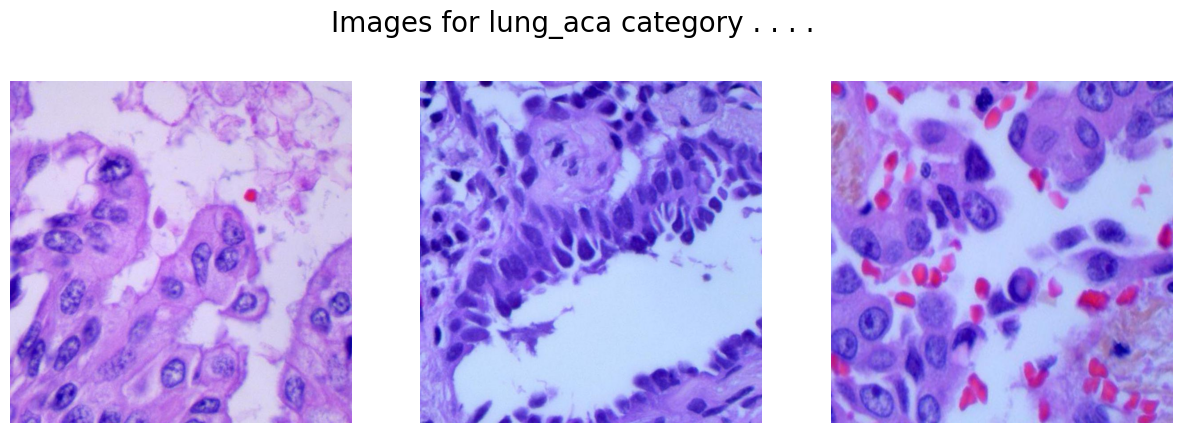

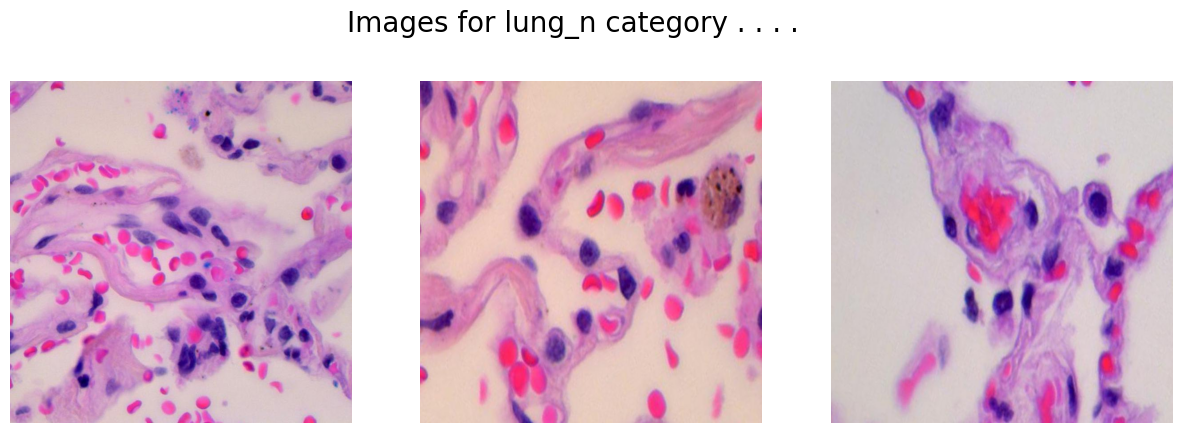

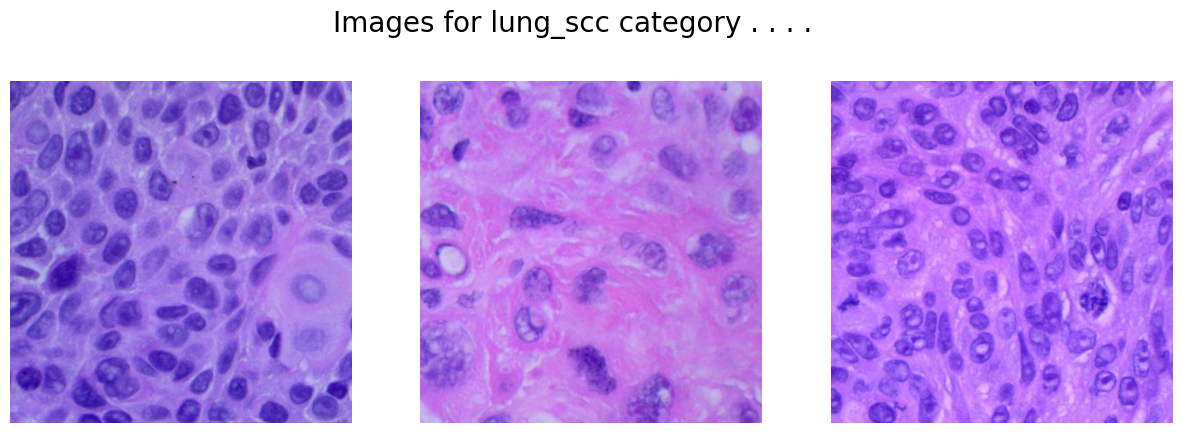

In [4]:
path = '/content/drive/MyDrive/datasets/lung_colon_image_set/lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


Data Preparation for Training

---
In this section, we will convert the given images into NumPy arrays of their pixels after resizing them because training a Deep Neural Network on large-size images is highly inefficient in terms of computational cost and time.

For this purpose, we will use the OpenCV library and Numpy library of python to serve the purpose. Also, after all the images are converted into the desired format we will split them into training and validation data so, that we can evaluate the performance of our model.


In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

Some of the hyperparameters which we can tweak from here for the whole notebook.

In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

for image in images:
	img = cv2.imread(image)

	X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
	Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

One hot encoding will help us to train a model which can predict soft probabilities of an image being from each class with the highest probability for the class to which it really belongs.

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


Y = np.array(Y)

# Convert the labels to a 1D array
Y_flattened = Y.ravel()

# Ensure the labels are one-hot encoded
one_hot_encoded_Y = to_categorical(Y_flattened)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size=SPLIT,
                                                  random_state=2022)

# Print the shapes to verify
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(4000, 256, 256, 3) (1000, 256, 256, 3)
(4000, 3) (1000, 3)


In this step, we will achieve the shuffling of the data automatically because the train_test_split function split the data randomly in the given ratio.

# Model Development
From this step onward we will use the TensorFlow library to build our CNN model. Keras framework of the tensor flow library contains all the functionalities that one may need to define the architecture of a Convolutional Neural Network and train it on the data.

**Model Architecture**
We will implement a Sequential model which will contain the following parts:



*   Three Convolutional Layers followed by MaxPooling Layers.

*   The Flatten layer to flatten the output of the convolutional layer.
*   Then we will have two fully connected layers followed by the output of the flattened layer.


*   We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.


*   The final layer is the output layer which outputs soft probabilities for the three classes.












In [8]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])

Let’s print the summary of the model’s architecture:

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

From above we can see the change in the shape of the input image after passing through different layers. The CNN model we have developed contains about 33.5 Million parameters. This huge number of parameters and complexity of the model is what helps to achieve a high-performance model which is being used in real-life applications.

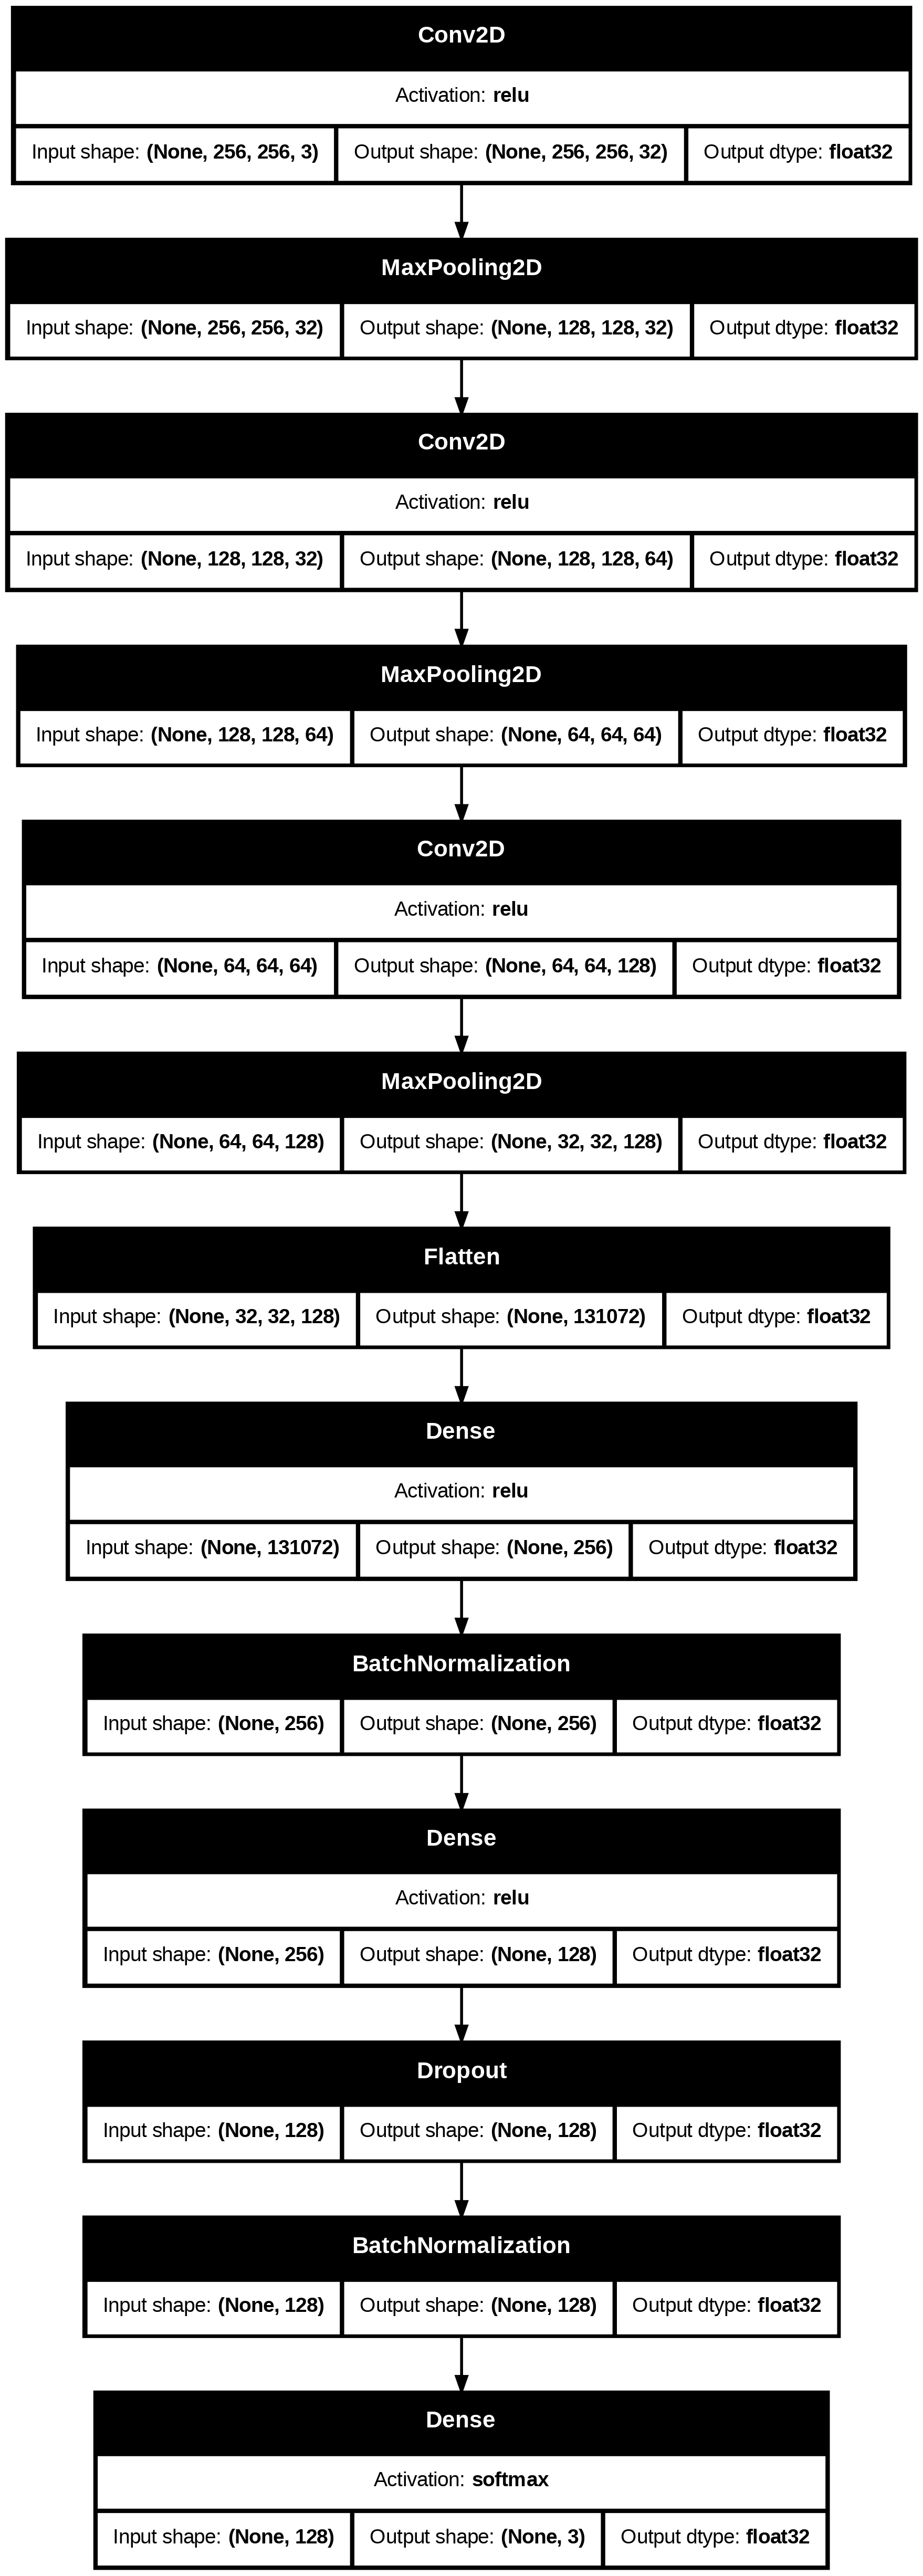

In [10]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

While compiling a model we provide these three essential parameters:



*   optimizer – This is the method that helps to optimize the cost function by using gradient descent.

*   loss – The loss function by which we monitor whether the model is improving with training or not.
*   metrics – This helps to evaluate the model by predicting the training and the validation data.









In [11]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)

**Callback**

---


Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases learning rate further. Even then if model performance is not improving then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

Now we will train our model:

In [13]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 859s 14s/step - accuracy: 0.4376 - loss: 1.2482 - val_accuracy: 0.0000e+00 - val_loss: 3.2108 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8724 - loss: 0.5442 
 Validation accuracy has reached upto 					90% so, stopping further training.
63/63 ━━━━━━━━━━━━━━━━━━━━ 853s 14s/step - accuracy: 0.8730 - loss: 0.5425 - val_accuracy: 1.0000 - val_loss: 0.0785 - learning_rate: 0.0010


Let’s visualize the training and validation accuracy with each epoch.

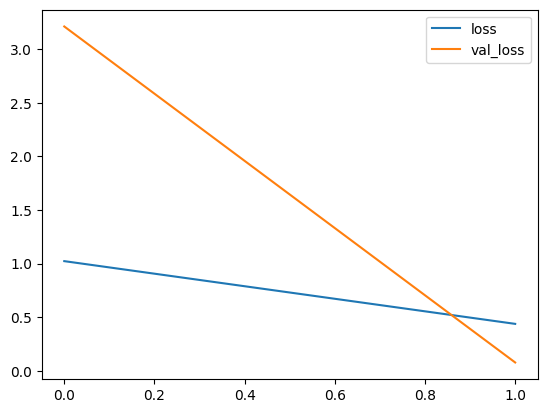

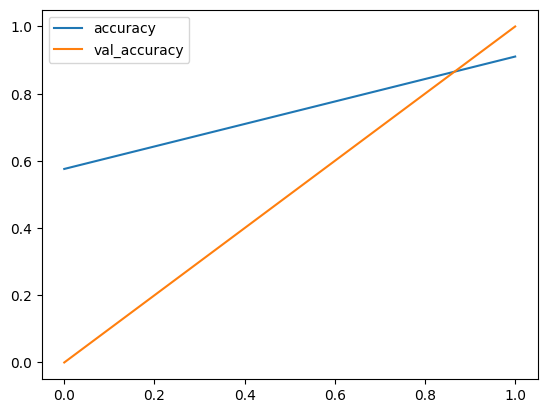

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

**Model Evaluation**

---

Now as we have our model ready let’s evaluate its performance on the validation data using different metrics. For this purpose, we will first predict the class for the validation data using this model and then compare the output with the true labels.

In [15]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step


Let’s draw the confusion metrics and classification report using the predicted labels and the true labels.

In [16]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[1000]])

In [19]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)

# Get unique classes from predictions and true labels
unique_classes = np.unique(np.concatenate((Y_val, Y_pred)))

# Filter target names to match unique classes
target_names = [classes[i] for i in unique_classes]

# Print classification report with filtered target names
print(metrics.classification_report(Y_val, Y_pred, target_names=target_names))

32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
              precision    recall  f1-score   support

    lung_scc       1.00      1.00      1.00      1000

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



# Conclusion:
Indeed the performance of our simple CNN model is very good as the f1-score for each class is above 0.90 which means our model’s prediction is correct over 90% of the time. This is what we have achieved with a simple CNN model.